<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-predicts" data-toc-modified-id="Load-predicts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load predicts</a></span></li><li><span><a href="#See-predictions-on-histograms" data-toc-modified-id="See-predictions-on-histograms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>See predictions on histograms</a></span></li><li><span><a href="#Explore-confusion-matrix" data-toc-modified-id="Explore-confusion-matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore confusion matrix</a></span></li><li><span><a href="#Create-new-predicts-with-f1-optimized-threshold" data-toc-modified-id="Create-new-predicts-with-f1-optimized-threshold-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create new predicts with f1 optimized threshold</a></span></li><li><span><a href="#Logloss-by-medium" data-toc-modified-id="Logloss-by-medium-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Logloss by medium</a></span></li><li><span><a href="#True-predictions-rates" data-toc-modified-id="True-predictions-rates-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>True predictions rates</a></span></li><li><span><a href="#ROC-curve" data-toc-modified-id="ROC-curve-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>ROC curve</a></span></li><li><span><a href="#Precision-recall-curve" data-toc-modified-id="Precision-recall-curve-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Precision recall curve</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import *
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
np.seterr(divide='ignore', invalid='ignore');

# Load predicts

In [2]:
# load predictions from csv file

test_predicts = 'data_files/scorer_test_predicts.csv'
test = pd.read_csv(test_predicts)
test.head(2)

,new_cid,weekday,source,clean_medium,camp,device_category,device_browser,device_browser_version,device_operating_system,device_operating_system_version,device_mobile_branding,device_mobile_model,step0,step1,step2,step3,step4,step5,step6,step7,step8,step9,step10,steps_all,is_booking,y_pred,y_pred_prob
0,new,Tuesday,facebook,facebook,facebook_rmkt_combinado_calculator,mobile,Chrome Mobile WebView,95.0.4638,Android,9,Generic_Android,moto e(6) plus,home,chalet,primary,insideUrban,streetLevel,garden,yes,yes,2_4hours,yes,yes,home-chalet-primary-insideUrban-streetLevel-ga...,0,0,0.0
1,new,Thursday,taboola,rest,ds_taboola_calculator,mobile,Chrome Mobile,91.0.4472,Android,7.0,LG,M250,home,chalet,primary,insideUrban,streetLevel,no,yes,yes,always,yes,yes,home-chalet-primary-insideUrban-streetLevel-no...,0,0,0.0


# See predictions on histograms

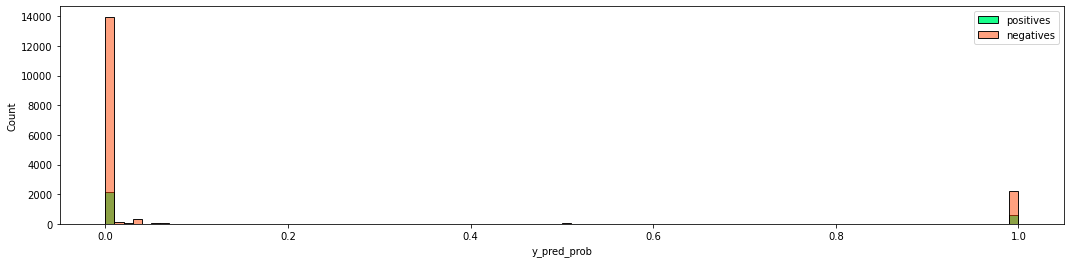

In [3]:
df_positives = test.loc[test['is_booking']==1]
df_negatives = test.loc[test['is_booking']==0]

fig, ax = plt.subplots(1,1, figsize=(18,4))

sns.histplot(df_positives['y_pred_prob'], bins=100, alpha=0.9, color='springgreen', label='positives')
sns.histplot(df_negatives['y_pred_prob'], bins=100, alpha=0.5, color='orangered', label='negatives')
plt.legend(loc='upper right');

# Explore confusion matrix

In [4]:
mediums = test['clean_medium'].value_counts().index.tolist()

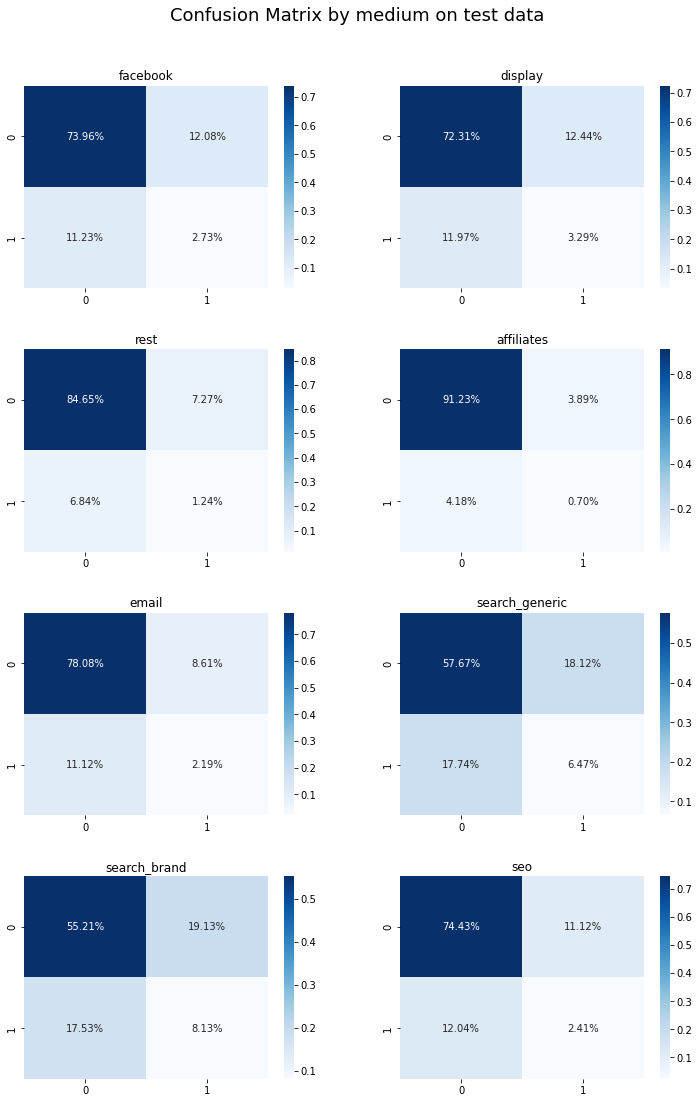

In [5]:
# confusion matrix by medium

fig, ax = plt.subplots(round(len(mediums)/2),2, figsize=(11, round(2*len(mediums))))
fig.suptitle('Confusion Matrix by medium on test data', size=18)
fig.tight_layout(pad=4)

for i, medium in enumerate(mediums):
    ax = ax.flatten()
    
    cf_matrix = confusion_matrix(test.loc[test['clean_medium']== medium]['is_booking'],
                                 test.loc[test['clean_medium']== medium]['y_pred'])
    
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax=ax[i]).set_title(medium);


# Create new predicts with f1 optimized threshold

In [6]:
# optimize threshold with best f1 score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
 
thresholds = np.arange(0, 1, 0.001)

# save f1 score for all iterations on threshold list, then retrieves the best score
scores = [f1_score(test['is_booking'], to_labels(test['y_pred_prob'], t)) for t in thresholds]
ix = np.argmax(scores)
best_thresh = thresholds[ix]

#if threshold is 0, sum min
if best_thresh < test[test['y_pred_prob'] > 0]['y_pred_prob'].min():
    best_thresh = test[test['y_pred_prob'] > 0]['y_pred_prob'].min()

# create new column for pred on tuned threshold
test.loc[:, 'y_pred_tuned'] = (test['y_pred_prob'] >= best_thresh).astype(int)

print('Threshold=%.3f, F1 Score=%.5f' % (best_thresh, f1_score(test['is_booking'], test['y_pred_tuned'])))

test.head(5)

Threshold=0.017, F1 Score=0.19112


,new_cid,weekday,source,clean_medium,camp,device_category,device_browser,device_browser_version,device_operating_system,device_operating_system_version,device_mobile_branding,device_mobile_model,step0,step1,step2,step3,step4,step5,step6,step7,step8,step9,step10,steps_all,is_booking,y_pred,y_pred_prob,y_pred_tuned
0,new,Tuesday,facebook,facebook,facebook_rmkt_combinado_calculator,mobile,Chrome Mobile WebView,95.0.4638,Android,9,Generic_Android,moto e(6) plus,home,chalet,primary,insideUrban,streetLevel,garden,yes,yes,2_4hours,yes,yes,home-chalet-primary-insideUrban-streetLevel-ga...,0,0,0.0,0
1,new,Thursday,taboola,rest,ds_taboola_calculator,mobile,Chrome Mobile,91.0.4472,Android,7.0,LG,M250,home,chalet,primary,insideUrban,streetLevel,no,yes,yes,always,yes,yes,home-chalet-primary-insideUrban-streetLevel-no...,0,0,0.0,0
2,new,Wednesday,facebook,facebook,facebook_ig_calculator,mobile,Instagram,216.0.0,iOS,14.8.1,Apple,"iPhone8,4",home,flat,primary,insideUrban,noGuardedUrbanization,balconyOrTerrace,no,no,2_4hours,no,no,home-flat-primary-insideUrban-noGuardedUrbaniz...,0,0,0.0,0
3,new,Wednesday,facebook,facebook,facebook_rmkt_PV_calculator,mobile,Facebook,326.0.0,Android,9,Generic_Android,moto e6s,home,chalet,primary,insideUrban,streetLevel,garden,yes,yes,always,no,no,home-chalet-primary-insideUrban-streetLevel-ga...,0,1,1.0,1
4,returning,Saturday,af_prospectone,email,af_prospectone_calculator,mobile,Chrome Mobile,96.0.4664,Android,6.0.1,Generic_Android,Le X522,home,flat,primary,insideUrban,streetLevel,garden,yes,yes,more4hours,yes,yes,home-flat-primary-insideUrban-streetLevel-gard...,0,0,0.0,0


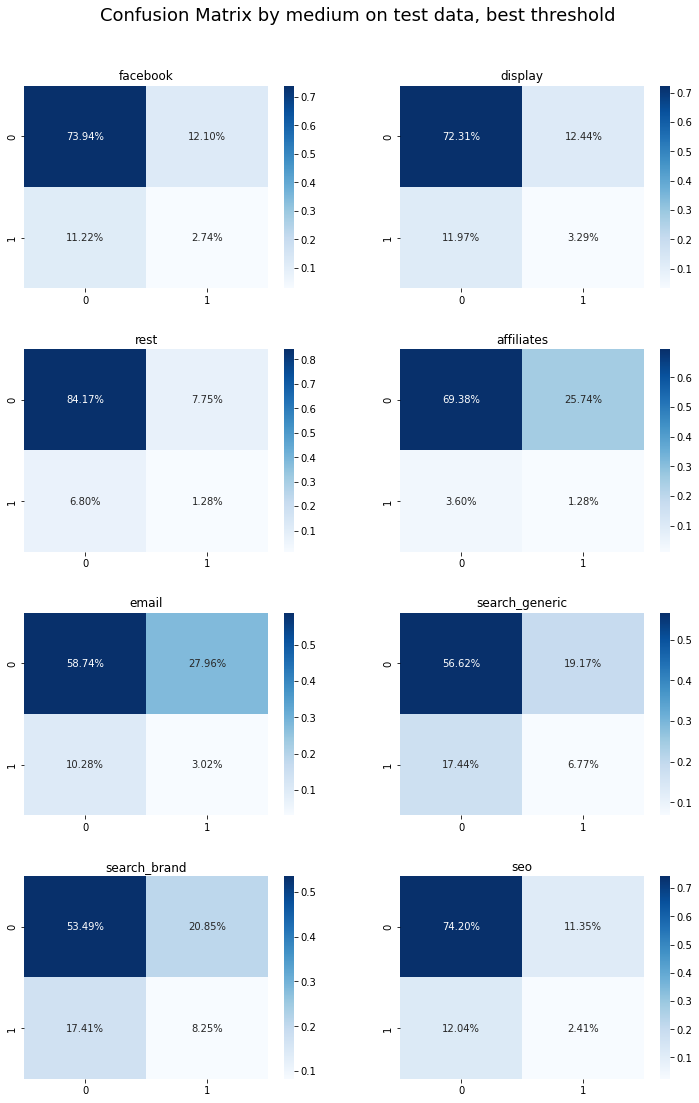

In [7]:
# confusion matrix by medium on best threshold

fig, ax = plt.subplots(round(len(mediums)/2),2, figsize=(11, round(2*len(mediums))))
fig.suptitle('Confusion Matrix by medium on test data, best threshold', size=18)
fig.tight_layout(pad=4)

for i, medium in enumerate(mediums):
    ax = ax.flatten()    
    
    cf_matrix = confusion_matrix(test.loc[test['clean_medium']== medium]['is_booking'],
                                 test.loc[test['clean_medium']== medium]['y_pred_tuned'])
    
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax=ax[i]).set_title(medium);

# Logloss by medium

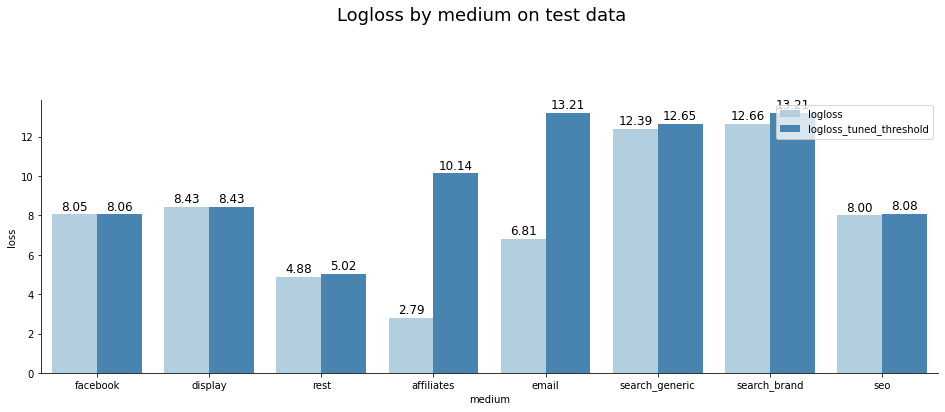

In [8]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
fig.suptitle('Logloss by medium on test data', size=18)
fig.tight_layout(pad=4)

losses = []
losses_tuned_threshold = []

for medium in mediums:    
    
    loss = log_loss(test.loc[test['clean_medium'] == medium]['is_booking'],
                    test.loc[test['clean_medium'] == medium]['y_pred'])
    losses.append(loss)
    
    loss_tuned = log_loss(test.loc[test['clean_medium'] == medium]['is_booking'],
                          test.loc[test['clean_medium'] == medium]['y_pred_tuned'])
    losses_tuned_threshold.append(loss_tuned)

# save results in a melted data frame    
d = {'medium': mediums, 'logloss': losses, 'logloss_tuned_threshold': losses_tuned_threshold}
df = pd.DataFrame(d)
melted = pd.melt(df, id_vars='medium', var_name='loss_type', value_name='loss')

sns.barplot(x='medium', y='loss', hue = 'loss_type', data=melted, palette='Blues', ax=ax)
sns.despine()
plt.legend(loc='upper right');

for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 8),
                       textcoords='offset points')

# True predictions rates

In [9]:
recall_score(test['is_booking'], test['y_pred_tuned'])

0.2196107234667646

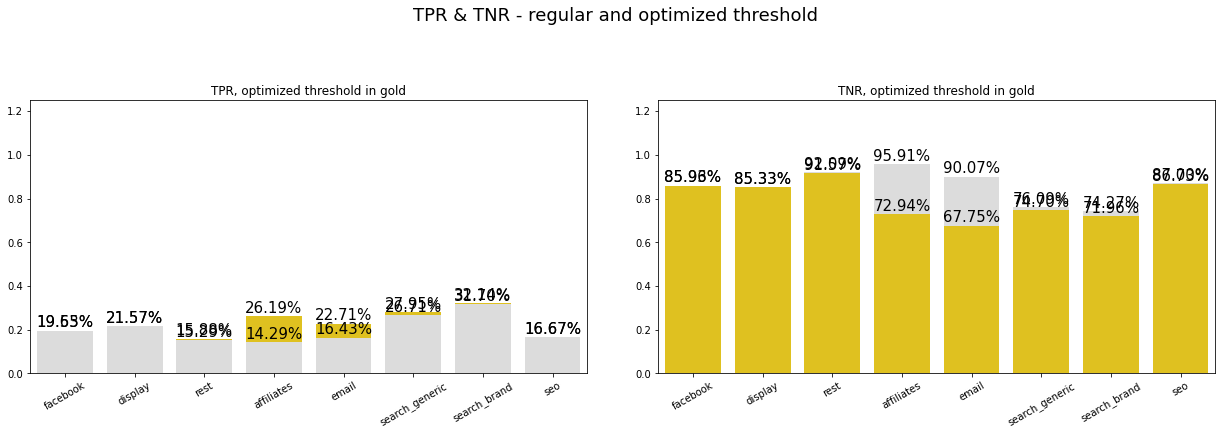

In [10]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle('TPR & TNR - regular and optimized threshold', size=18)
fig.tight_layout(pad=4)

tprs = []
tnrs = []
fprs = []
fnrs = []

tprs_tuned = []
tnrs_tuned = []
fprs_tuned = []
fnrs_tuned = []

for medium in mediums:   
    ytest = test.loc[test['clean_medium'] == medium]['is_booking']
    ypred = test.loc[test['clean_medium'] == medium]['y_pred']
    ypred_tuned = test.loc[test['clean_medium'] == medium]['y_pred_tuned']
    
    tpr = recall_score(ytest, ypred)
    tnr = recall_score(ytest, ypred, pos_label=0) 
    fpr = 1 - tnr
    fnr = 1 - tpr
    tprs.append(tpr)
    tnrs.append(tnr)
    fprs.append(fpr)
    fnrs.append(fnr)

    tpr_tuned = recall_score(ytest, ypred_tuned)
    tnr_tuned = recall_score(ytest, ypred_tuned, pos_label=0) 
    fpr_tuned = 1 - tpr_tuned
    fnr_tuned = 1 - tnr_tuned
    tprs_tuned.append(tpr_tuned)
    tnrs_tuned.append(tnr_tuned)
    fprs_tuned.append(fpr_tuned)
    fnrs_tuned.append(fnr_tuned)
    
ax = ax.flatten()

sns.barplot(x=mediums, y=tprs_tuned, color='gold',
            ax=ax[0])

sns.barplot(x=mediums, y=tprs, color='gainsboro',
            ax=ax[0]).set(title='TPR, optimized threshold in gold')

sns.barplot(x=mediums, y=tnrs, color='gainsboro',
            ax=ax[1])

sns.barplot(x=mediums, y=tnrs_tuned, color='gold',
            ax=ax[1]).set(title='TNR, optimized threshold in gold');

for ax in ax:
    
    ax.tick_params(axis='x', rotation=30)
    ax.set_ylim(0,1.25)
    
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2%'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=15, xytext=(0, 8),
                        textcoords='offset points')
    

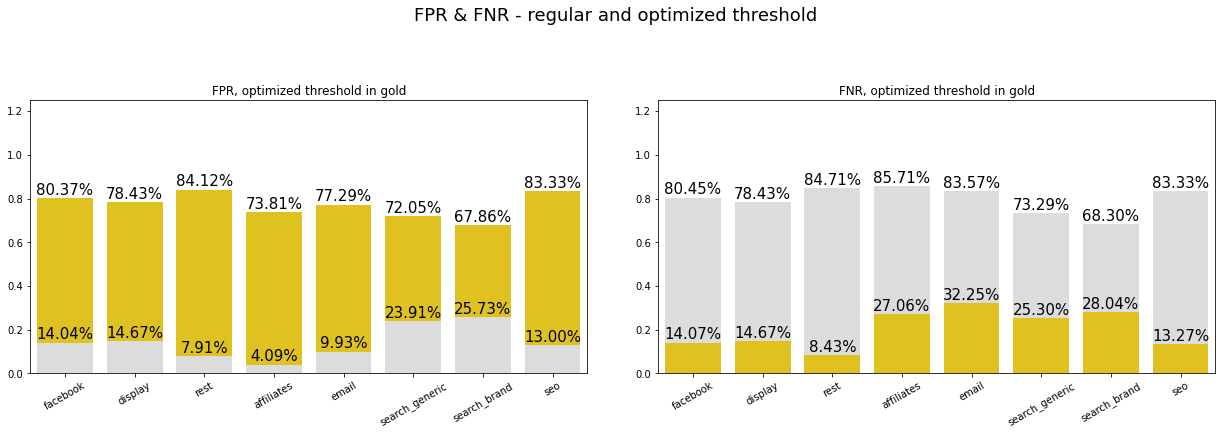

In [11]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle('FPR & FNR - regular and optimized threshold', size=18)
fig.tight_layout(pad=4)

ax = ax.flatten()
    
sns.barplot(x=mediums, y=fprs_tuned, color='gold',
            ax=ax[0])
    
sns.barplot(x=mediums, y=fprs, color='gainsboro',
            ax=ax[0]).set(title='FPR, optimized threshold in gold')

sns.barplot(x=mediums, y=fnrs, color='gainsboro',
            ax=ax[1])

sns.barplot(x=mediums, y=fnrs_tuned, color='gold',
            ax=ax[1]).set(title='FNR, optimized threshold in gold');

for ax in ax:
    
    ax.tick_params(axis='x', rotation=30)
    ax.set_ylim(0,1.25)
    
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2%'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=15, xytext=(0, 8),
                        textcoords='offset points')

# ROC curve

In [12]:
len(test[test['is_booking']==1]) / len(test)

0.13873038516405137

Best threshold=0.250, G-mean=0.429


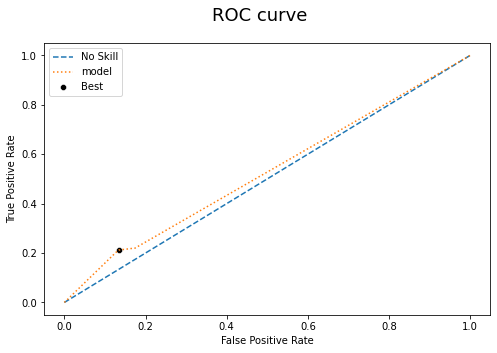

In [13]:
# best threshold for ROC curve

fpr, tpr, thresholds = roc_curve(test['is_booking'], test['y_pred_prob'])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best threshold=%.3f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('ROC curve', size=18)
sns.lineplot([0,1], [0,1], linestyle='--', label='No Skill')
sns.lineplot(fpr, tpr, linestyle='dotted', label='model')
sns.scatterplot(fpr[ix], tpr[ix].reshape(-1), marker='o', color='black', label='Best')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');


facebook best threshold=0.500, G-mean=0.411 

display best threshold=1.000, G-mean=0.429 

rest best threshold=0.500, G-mean=0.382 

affiliates best threshold=0.031, G-mean=0.440 

email best threshold=0.250, G-mean=0.399 

search_generic best threshold=0.500, G-mean=0.459 

search_brand best threshold=1.000, G-mean=0.487 

seo best threshold=1.000, G-mean=0.381 



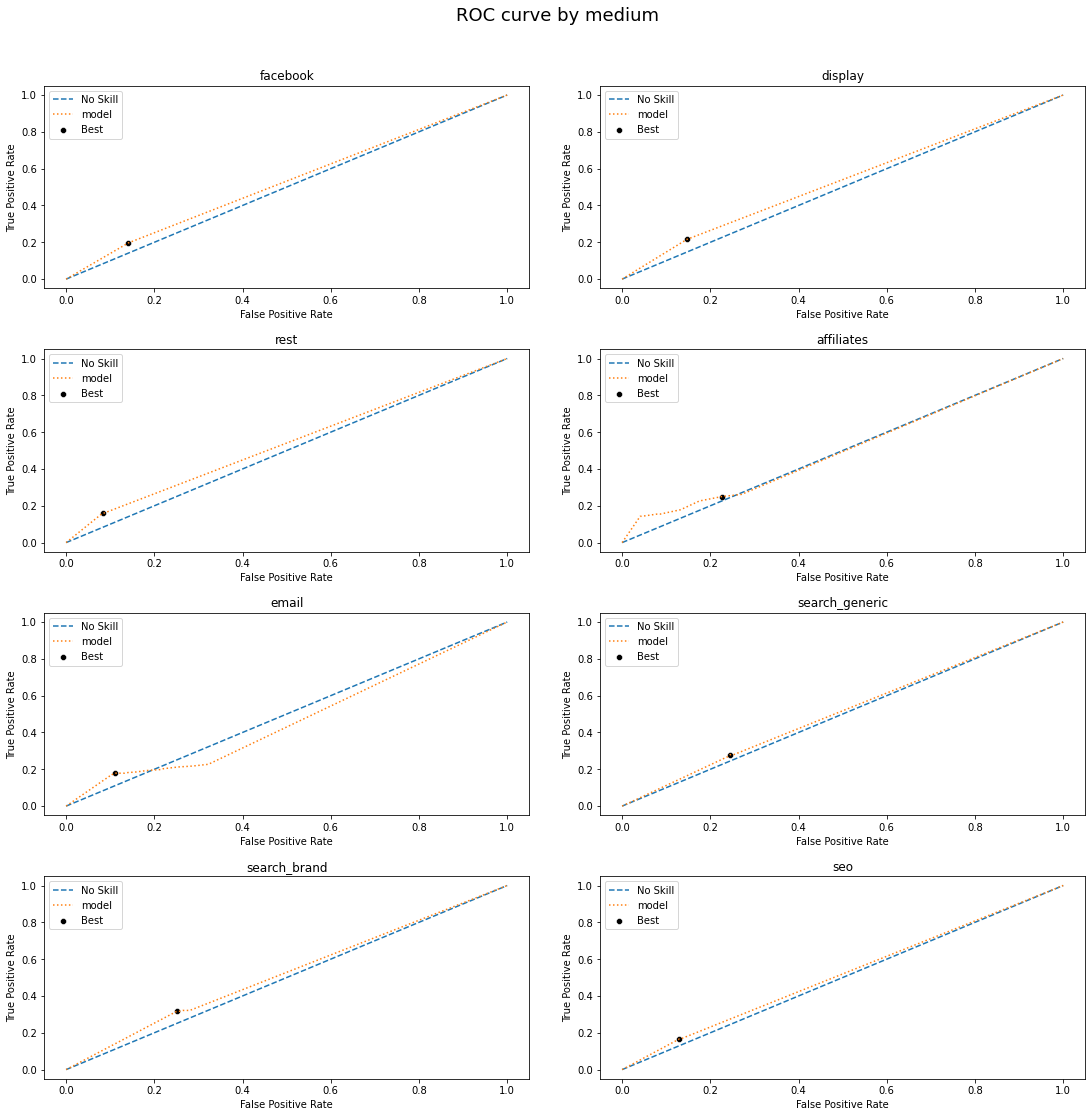

In [14]:
# ROC curve by medium

fig, ax = plt.subplots(round(len(mediums)/2),2, figsize=(16, round(2*len(mediums))))
fig.suptitle('ROC curve by medium', size=18)
fig.tight_layout(pad=4)

for i, medium in enumerate(mediums):
    ax = ax.flatten()
    
    ytest = test.loc[test['clean_medium'] == medium]['is_booking']
    ypred_prob = test.loc[test['clean_medium'] == medium]['y_pred_prob']
    fpr, tpr, thresholds = roc_curve(ytest, ypred_prob)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    
    print(medium, 'best threshold=%.3f, G-mean=%.3f \n' % (thresholds[ix], gmeans[ix]))

    sns.lineplot([0,1], [0,1], linestyle='--', label='No Skill', ax=ax[i]).set_title(medium)
    sns.lineplot(fpr, tpr, linestyle='dotted', label='model', ax=ax[i])
    sns.scatterplot(fpr[ix], tpr[ix].reshape(-1), marker='o', color='black', label='Best', ax=ax[i])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')


# Precision recall curve

Best threshold=0.000, F-score=0.244


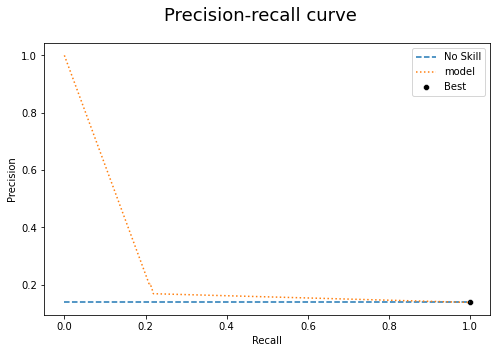

In [15]:
# best threshold for Precision-Recall curve

precision, recall, thresholds = precision_recall_curve(test['is_booking'], test['y_pred_prob'])

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best threshold=%.3f, F-score=%.3f' % (thresholds[ix], fscore[ix]))

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Precision-recall curve', size=18)
no_skill = len(test.loc[test['is_booking']==1]) / len(test['is_booking'])
sns.lineplot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
sns.lineplot(recall, precision, linestyle='dotted', label='model')
sns.scatterplot(recall[ix], precision[ix].reshape(-1), marker='o', color='black', label='Best')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');


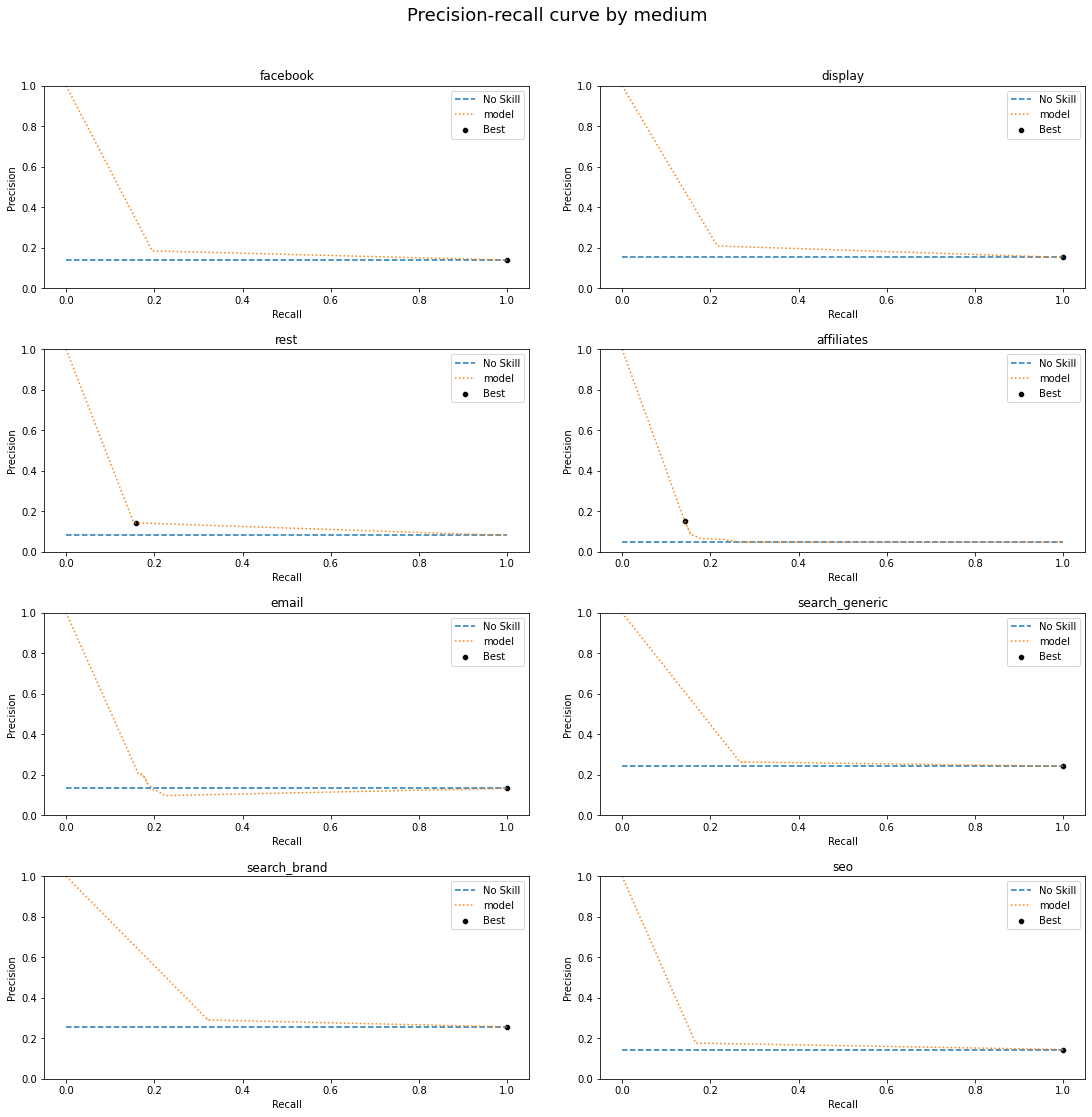

In [16]:
# precision-recall curve by medium

fig, ax = plt.subplots(round(len(mediums)/2),2, figsize=(16, round(2*len(mediums))))
fig.suptitle('Precision-recall curve by medium', size=18)
fig.tight_layout(pad=4)

for i, medium in enumerate(mediums):
    ax = ax.flatten()
    
    ytest = test.loc[test['clean_medium'] == medium]['is_booking']
    ypred_prob = test.loc[test['clean_medium'] == medium]['y_pred_prob']
    precision, recall, thresholds = precision_recall_curve(ytest, ypred_prob)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)

    no_skill = len(ytest[ytest==1]) / len(ytest)
    sns.lineplot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', ax=ax[i]).set_title(medium)
    sns.lineplot(recall, precision, linestyle='dotted', label='model', ax=ax[i])
    sns.scatterplot(recall[ix], precision[ix].reshape(-1), marker='o', color='black', label='Best', ax=ax[i])
    ax[i].set(xlabel='Recall', ylabel='Precision', ylim=(0,1))
